# Read data

In [102]:
#structure of .mat file
from scipy.io import loadmat
x = loadmat(r'C:\Users\91935\Downloads\DTS201TC coursework\DTS201TC coursework\Salinas_corrected.mat')
sorted(x.keys())

['__globals__', '__header__', '__version__', 'salinas_corrected']

In [103]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

In [104]:
from scipy.io import loadmat

def image_read():
    X = loadmat('./Salinas_corrected.mat')['salinas_corrected']
    y = loadmat('./Salinas_gt.mat')['salinas_gt']
    print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X,y

In [105]:
# read the data and standarlization
X,y = image_read() 

X shape: (512, 217, 204)
y shape: (512, 217)


# Data preprocessing

#### Remark: The commented code is a test on our identified limitation:  Adding a Gaussian Blurring

In [106]:
# from skimage.filters import gaussian
# X = gaussian(X, sigma=5, channel_axis=True)

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. reshape 3D to 2D
X = np.reshape(X, (-1,X.shape[2])) #training examples
y = y.flatten() #labels

# 2. standarlization
scaler = StandardScaler() 
X = scaler.fit_transform(X)

# 3. remove labels '0'(not targeted objects)
idx_arr = np.argwhere(y == 0).flatten()
mask = np.ones_like(y).astype(bool)
mask[idx_arr] = False

X_target = np.ones_like(X)
X_target= X[mask]

y_without = y[mask]

# PCA - dimension reduction

In [108]:
# To visualize PCA result(10 largest) and find a proper number of 'n_components'
def find_pca_num_visual(data, threshold):
    pca = PCA()
    pca.fit(data)
    
    # Visualization Before Finding a Proper Number of 'n_components'
    # Plot 10 largest principle components for PCA
    plt.figure(figsize = (13,4))
    plt.subplots_adjust(wspace=0.2)
    plt.subplot(1,2,1).set_title('Feature Importance (10 largest)')
    xticks = [f'PCA{i+1}' for i in range(10)]
    plt.bar(xticks, pca.explained_variance_ratio_[0:10])
    plt.subplot(1,2,2).set_title('Cumulative Variance Ratio')
    plt.plot(pca.explained_variance_ratio_.cumsum())
#     print(pca.explained_variance_ratio_.cumsum())

 # Find a Proper Number of 'n_components'  
    num_components = 0
    for i in pca.explained_variance_ratio_.cumsum():
        if i <= threshold:
            num_components += 1
    return num_components

The number of principle components selected is 5, which captures 99.0% variance of data.


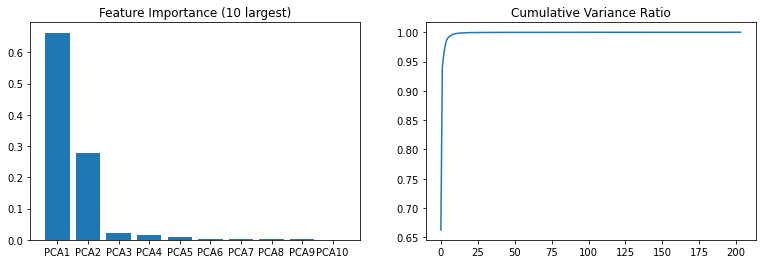

In [109]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Find a proper number of 'n_components' by setting a threshold for the variance capture ratio
# Supposed that the threshold equals 99%
threshold = 0.99
num_components = find_pca_num_visual(X_target, threshold)
print(f"The number of principle components selected is {num_components}, which captures {threshold*100}% variance of data.")

In [110]:
# Get the data after feature seletion
pca = PCA(n_components=num_components)
X_new = pca.fit_transform(X_target)

# Feature Visualization (After PCA)

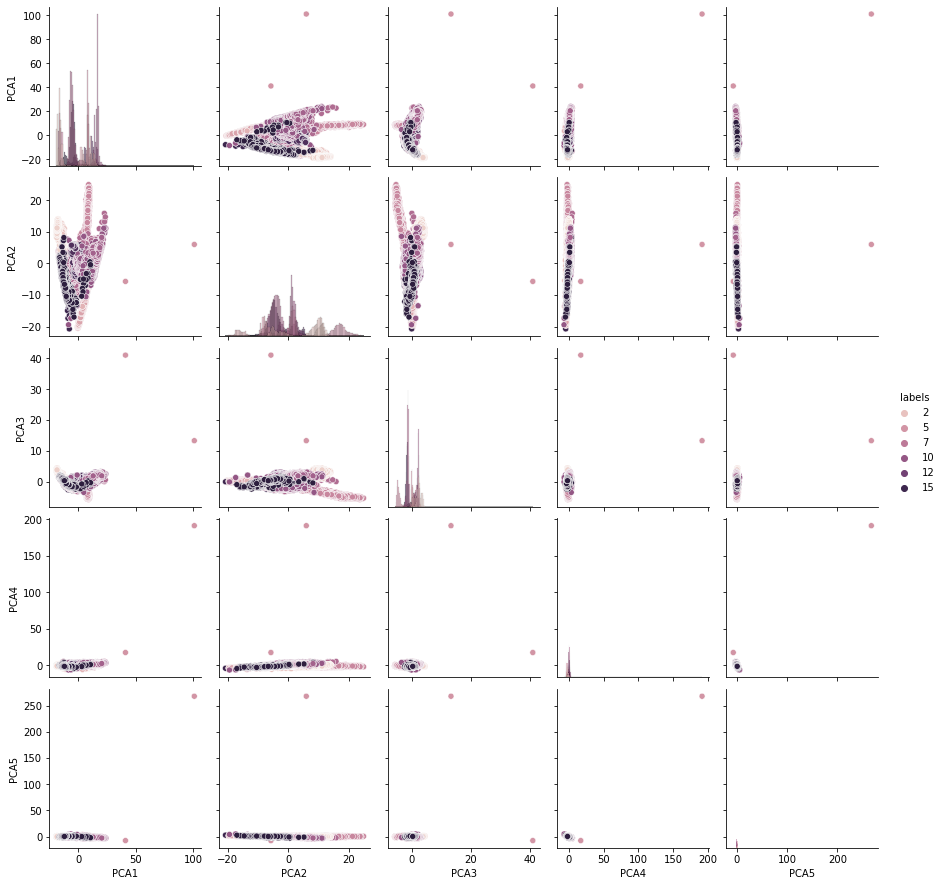

In [111]:
# the pairwise scatter plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Salinas_features = pd.DataFrame(data = X_new) #transform training examples to dataframe format
Salinas_features.columns = [f'PCA{i}'for i in range(1,X_new.shape[1]+1)]

Salinas_all = Salinas_features.copy() #use copy to avoid writing to the original data
Salinas_all['labels'] = y_without #combine features and labels 

# salinas_all.head()
# salinas_all.tail()

# scatter plots of combinations of features and labels 
sns.pairplot(data=Salinas_all,diag_kind='hist', hue= 'labels')
plt.show()

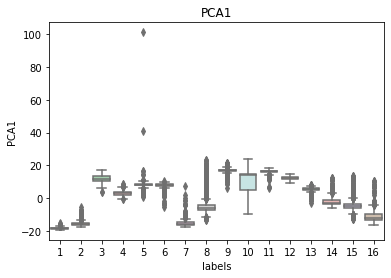

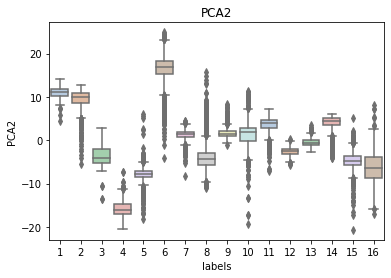

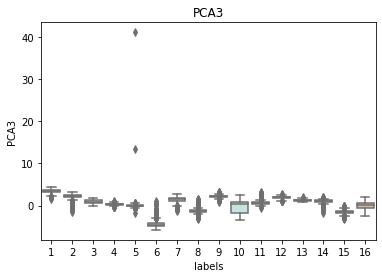

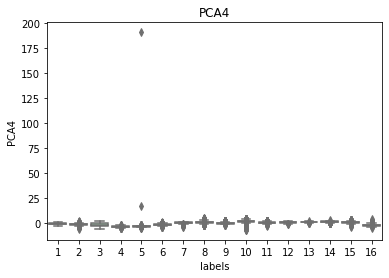

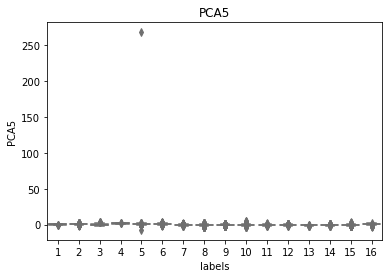

In [112]:
"""
box plot - to compare differences between 
each class's distribution in feature space 

"""
for col in Salinas_features.columns:
    sns.boxplot(x='labels', y=col, saturation=0.5,palette='pastel', data=Salinas_all)
    plt.title(col)
    plt.show()

# SVM Classifier

In [123]:
# generate training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Salinas_features,y_without,test_size = 0.2,
                                                     random_state = 88)


In [124]:
from sklearn.svm import SVC
svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)
svm.fit(x_train,y_train)


SVC(C=100, cache_size=10240)

In [129]:
# Prediction
from sklearn import metrics
y_pred = svm.predict(x_test)
print("The accuracy is:",metrics.accuracy_score(y_test,y_pred))

The accuracy is: 0.9040273415850729


In [128]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm,x_train,y_train,cv=5,n_jobs=4)
print('Mean cross validation score: ', scores.mean())

Mean cross validation score:  0.9084589861962508


### Plot bar chart of the test result

In [116]:
def plot_histogram_compare_predict_expect(predict, true):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py" 
    '''
    Plot histogram and compare to predictions histogram
    params
    ----------
    predict: Predictions array of shape (n_samples,)
    expect: Expectations array of shape (n_samples,)
    title: Matplotlib title
    '''
    fig, axs = plt.subplots(figsize=(20, 6))

    bar_x, bar_count_pred = np.unique(predict, return_counts=True)
    bar1 = axs.bar(bar_x - 0.2, bar_count_pred, 0.4, label="Predicted")

    bar_x, bar_count_exp = np.unique(true, return_counts=True)
    bar2 = axs.bar(bar_x + 0.2, bar_count_exp, 0.4, label="True")

    axs.bar_label(bar1, padding=3)
    axs.bar_label(bar2, padding=3)

    axs.set_xticks(np.arange(1,len(bar_x)+1))
    axs.set_xticklabels(bar_x)

    axs.set_title('Number of Predicted and True Labels', fontdict={'size':17})
    axs.legend()
    plt.show()

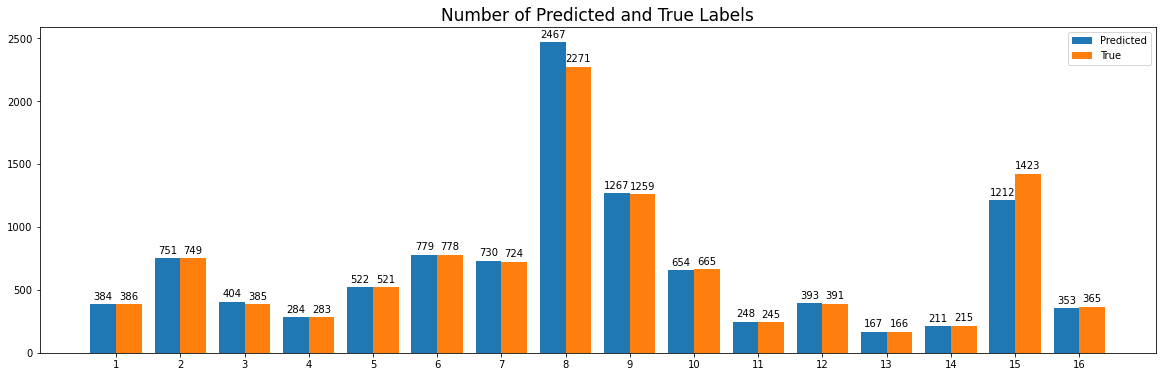

In [117]:
plot_histogram_compare_predict_expect(y_pred, y_test)

### Plot the confusion matrix of the test result

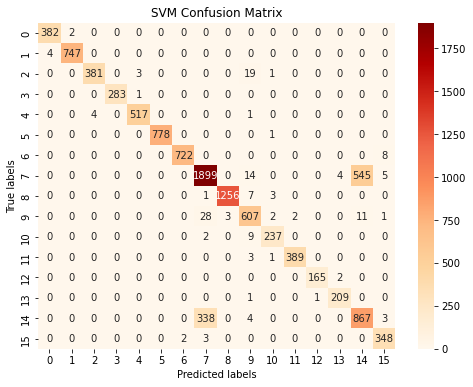

In [118]:
# visualize the confusion matrix using heat map
confusion_matrix = metrics.confusion_matrix(y_pred,y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,annot=True, fmt='g', cmap='OrRd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Confusion Matrix')
plt.show()


In [119]:
target_names = [f'class{i}'for i in range(1,17)]
print(metrics.classification_report(y_test,y_pred,target_names = target_names))

              precision    recall  f1-score   support

      class1       0.99      0.99      0.99       386
      class2       0.99      1.00      1.00       749
      class3       0.94      0.99      0.97       385
      class4       1.00      1.00      1.00       283
      class5       0.99      0.99      0.99       521
      class6       1.00      1.00      1.00       778
      class7       0.99      1.00      0.99       724
      class8       0.77      0.84      0.80      2271
      class9       0.99      1.00      0.99      1259
     class10       0.93      0.91      0.92       665
     class11       0.96      0.97      0.96       245
     class12       0.99      0.99      0.99       391
     class13       0.99      0.99      0.99       166
     class14       0.99      0.97      0.98       215
     class15       0.72      0.61      0.66      1423
     class16       0.99      0.95      0.97       365

    accuracy                           0.90     10826
   macro avg       0.95   

In [120]:
y_pred_full = svm.predict(Salinas_features)

In [121]:
# Padding the background for plotting
idx_arr1 = np.argwhere(y != 0).flatten()
salinas_img_pred = np.zeros_like(y)
salinas_img_pred[idx_arr1] = y_pred_full
print(salinas_img_pred.shape)
print(y.shape)

(111104,)
(111104,)


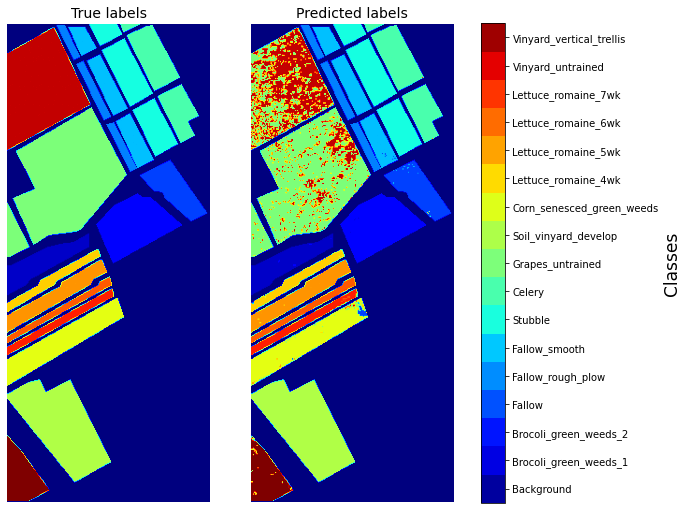

In [122]:
labels = np.dstack((y.reshape(512,217),salinas_img_pred.reshape(512, 217)))
titles = ['True labels', 'Predicted labels']
fig, axs = plt.subplots(1, 2, figsize=(10, 14))
for col in range(2):
    ax = axs[col]
    ax.axis('off')
    pcm = ax.imshow(labels[:,:,col], cmap='jet')
    ax.set_title(titles[col],fontdict = {'size':14})
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs.ravel().tolist(), boundaries=(np.arange(NUM_CLASSES + 2) - 0.5),shrink=0.63)
cbar.set_label('Classes', fontdict = {'size':17})
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)